# Proyecto 1

Imanol Muñiz Ramirez A01701713

María José Soto Cástro A01705840

Rodrigo Antonio Benítez De La Portilla A01771433

## Objetivo 1

### 1.a Provide understanding of the candy category by manufacturermarket share composition by year

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Cargar datos
try:
    df_catalog = pd.read_csv('./DATA_CATALOG_2024.csv', encoding='latin1')
    df_sales = pd.read_csv('./DATOS_VENTA_2024.csv',)
    print("Archivos de datos cargados exitosamente.")
except FileNotFoundError:
    print("Error: Los archivos 'DATA_CATALOG_2024.csv' o 'DATOS_VENTA_2024.csv' no se encontraron.")
    print("Asegúrate de que estén en la misma carpeta que el script y vuelve a intentarlo.")
    exit()

Archivos de datos cargados exitosamente.


In [63]:
print("Primeras filas del catálogo:")
print(df_catalog.head())
print("\nPrimeras filas de las ventas:")
print(df_sales.head())

Primeras filas del catálogo:
          ID   FAB                               PRODUCT CATEGORY SUBCATEGORY  \
0  981024284  FAB1                  6PZ CALAVERA       A    OTROS   HALLOWEEN   
1     157612  FAB2             RG 36/30GR MAZAPAN AZTECA    CANDY    REGIONAL   
2      46571  FAB3  PALETA CALABACITA AGRIDULCE 30 PZAS.    SPICY       SPICY   
3     743164  FAB3   DRAGONZITOS 300PZ DRAGONZITOS 300PZ    SPICY       SPICY   
4     225218  FAB3                   MOZTRITOS COLGANTES    SPICY   HALLOWEEN   

      TYPE  
0  SEASONS  
1  REGULAR  
2  REGULAR  
3  REGULAR  
4  SEASONS  

Primeras filas de las ventas:
  CORTE         ID  ANIO  MES       FECHA       VALOR UNIDADES VOLUMEN
0    TN  981005567  2020    1  01/01/2020  $2,026,034   18,396  18,396
1    TN     265754  2020    1  01/01/2020    $622,827    6,346   6,346
2    TN  980017513  2020    1  01/01/2020    $276,840    2,805   2,805
3    TN  981008733  2020    1  01/01/2020  $5,709,468   43,632  43,632
4    TN  980015450  

Tenemos dos archivos de datos. El primero de ellos es un catálogo de los productos que vende cada fabricante. El otro contiene las ventas de cada producto por mes en casi 5 años. Dado que búscamos mostrar entendimiento del mercado de dulces tenemos que generar las tablas que nos permitan visualizar información relevante.

Para comprender la repartición del mercado vamos a generar una tabla con las ventas de cada año por fabricante. De esta forma podrémos apreciar la distribución de ventas, qué fabricantes generan más valor y qué parte del mercado sustentan. 

Limpieza y merge de los datos

In [64]:
# Limpiar la columna VALOR
df_sales['VALOR'] = (
    df_sales['VALOR']
    .replace(r'[\$,]', '', regex=True) 
    .astype(float)
)

# Agregar ventas por ID y año
df_yearly = (
    df_sales
    .groupby(['ID', 'ANIO'], as_index=False)['VALOR']
    .sum()
)

# Pivotear la tabla para tener años como columnas
df_pivot = df_yearly.pivot(index='ID', columns='ANIO', values='VALOR').reset_index()
df_pivot.columns = [str(c) for c in df_pivot.columns]

# Forzar que existan las columnas de 2020 a 2024 aunque falten
for year in ['2020', '2021', '2022', '2023', '2024']:
    if year not in df_pivot.columns:
        df_pivot[year] = 0

# Convertir a numérico por seguridad
df_pivot[['2020', '2021', '2022', '2023', '2024']] = (
    df_pivot[['2020', '2021', '2022', '2023', '2024']].apply(pd.to_numeric, errors='coerce').fillna(0)
)

# Unir con catálogo
df_final = df_catalog.merge(df_pivot, on='ID', how='left').fillna(0)

# Filtrar por la categoría 'CANDY'
df_candy = df_final[df_final['CATEGORY'] == 'CANDY'].copy()

# Agrupar por fabricante y sumar ventas anuales
df_candy_fab = (
    df_candy.groupby('FAB')[['2020', '2021', '2022', '2023', '2024']]
    .sum()
    .reset_index()
)


Decidimos solo tomar aquellos fabricantes que engloben el 80% del mercado con el objetivo de poder visualizar mejor los gráficos y apelando al principio de Pareto que indica para este caso que el 80% de las ventas se estarían generando por el 20% de los fabricantes aproximadamente. 

Filtrado y generación de nuevas columnas.

In [65]:
# Filtrar solo CANDY
df_candy = df_final[df_final['CATEGORY'] == 'CANDY'].copy()

# Agrupar por fabricante y sumar ventas
df_candy_fab = (
    df_candy.groupby('FAB')[['2020','2021','2022','2023','2024']]
    .sum()
    .reset_index()
)

# Calcular el total acumulado de cada fabricante en todos los años
df_candy_fab['TOTAL'] = df_candy_fab[['2020','2021','2022','2023','2024']].sum(axis=1)

# Ordenar fabricantes por ventas totales
df_candy_fab = df_candy_fab.sort_values(by='TOTAL', ascending=False)

# Calcular participación porcentual y acumulada
df_candy_fab['SHARE'] = df_candy_fab['TOTAL'] / df_candy_fab['TOTAL'].sum()
df_candy_fab['CUM_SHARE'] = df_candy_fab['SHARE'].cumsum()

# Filtrar solo fabricantes que conforman el 80% del mercado
df_candy_fab_top = df_candy_fab[df_candy_fab['CUM_SHARE'] <= 0.8].copy()

# Lista de fabricantes top 80%
top_fabs = df_candy_fab_top['FAB'].unique()

Gráficos

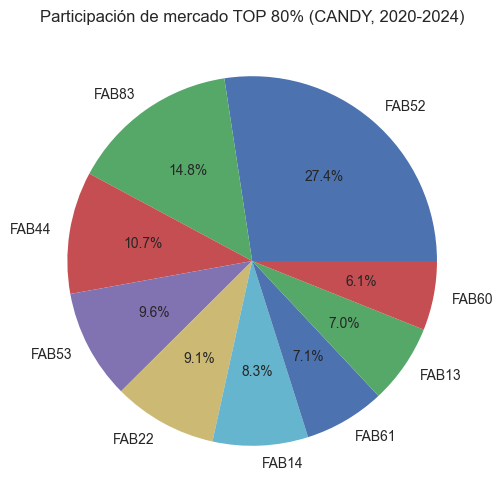

In [66]:
# --- Pie chart con top 80% ---
plt.figure(figsize=(8,6))
plt.pie(df_candy_fab_top['TOTAL'], labels=df_candy_fab_top['FAB'], autopct='%1.1f%%')
plt.title("Participación de mercado TOP 80% (CANDY, 2020-2024)")
plt.show()

Podemos apreciar como tan solo 9 de los 87 facbricantes tienen el 80% del mercado de dulces, siendo FAB52 y FAB83 los que se tienen mayor parte.

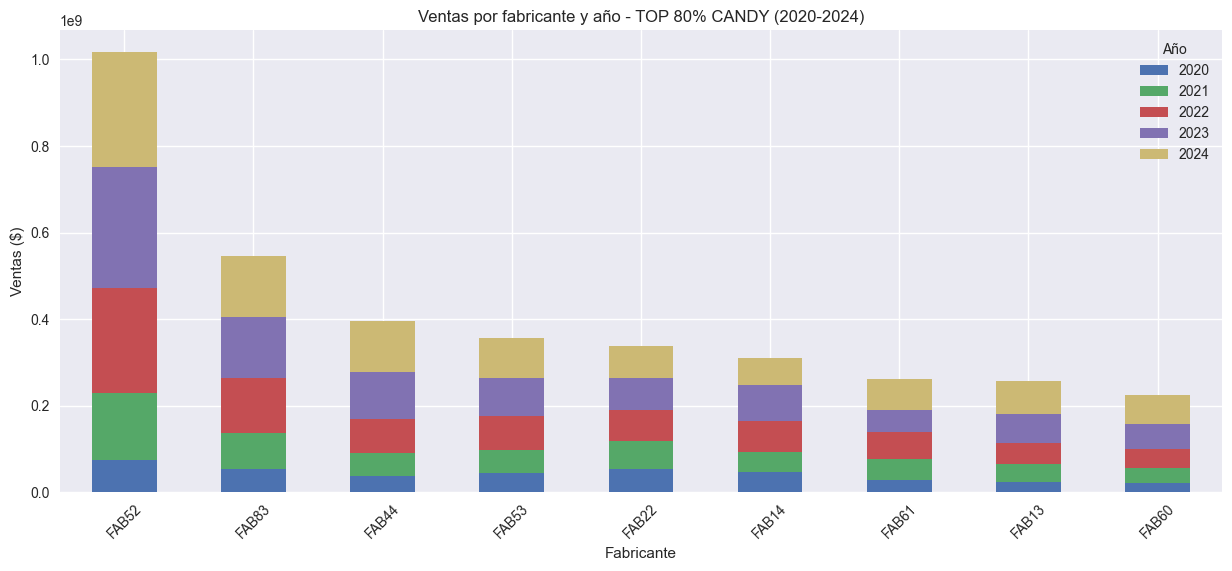

In [67]:
# --- Barras stacked por año solo top 80% ---
fig, ax = plt.subplots(figsize=(15,6))
df_candy_fab_top.set_index('FAB')[['2020','2021','2022','2023','2024']].plot(
    kind='bar', stacked=True, ax=ax
)

ax.set_title("Ventas por fabricante y año - TOP 80% CANDY (2020-2024)")
ax.set_xlabel("Fabricante")
ax.set_ylabel("Ventas ($)")
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.show()

df_candy_fab_top.to_csv('./CANDY_MARKET_SHARE.csv', index=False)

Para el año 2022, FAB52 ya vendía lo las demás FABs en el año 2024. FAB83 en el año 2023 vendía lo que las demás en el año 2024. 

### 1.b Provide understanding of the candy category by manufacturer sales and price performance over time.

Para este punto vamos a generar distintos gráficos para observar el cómo los cambios en los precios de los dulces han provocado cambios en el volumen de ventas y en el valor generado por cada fabricante. Para esto primero creamos una nueva tabla que contenga el precio promedio de todos los productos de cada fabricante.

Primero filtramos y obtenemos los datos que necesitamos visualizar

In [68]:
# --- Partimos de df_sales (todas las ventas) y df_catalog ---
# Filtrar solo CANDY
df_catalog_candy = df_catalog[df_catalog['CATEGORY'] == 'CANDY']

# Merge para quedarnos con info de FAB en las ventas
df_candy_sales = df_sales.merge(df_catalog_candy[['ID','FAB']], on='ID', how='inner')

# --- Limpieza de UNIDADES ---
df_candy_sales['UNIDADES'] = (
    df_candy_sales['UNIDADES']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# --- Agrupar por FAB y ANIO ---
df_candy_perf = (
    df_candy_sales
    .groupby(['FAB','ANIO'], as_index=False)
    .agg({'VALOR':'sum','UNIDADES':'sum'})
)
df_candy_perf_top = df_candy_perf[df_candy_perf['FAB'].isin(top_fabs)]
print(df_candy_perf_top.head())

# --- Calcular precio promedio ---
df_candy_perf_top['PRECIO_PROM'] = df_candy_perf_top['VALOR'] / df_candy_perf_top['UNIDADES']

df_candy_perf_top.to_csv('./CANDY_SALES_PERF.csv', index=False)

     FAB  ANIO       VALOR   UNIDADES
2  FAB13  2020  23745310.0   617561.0
3  FAB13  2021  42111048.0  1035894.0
4  FAB13  2022  48468074.0  1141829.0
5  FAB13  2023  66058902.0  1394470.0
6  FAB13  2024  77900858.0  1482809.0


C:\Users\Imanol\AppData\Local\Temp\ipykernel_17056\658400363.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_candy_perf_top['PRECIO_PROM'] = df_candy_perf_top['VALOR'] / df_candy_perf_top['UNIDADES']


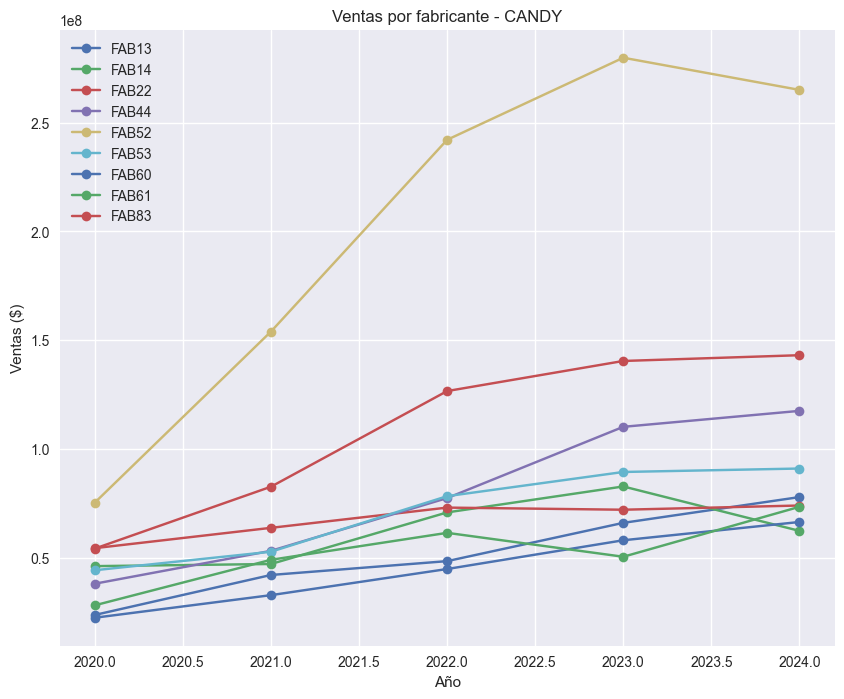

In [69]:
# Gráfico de líneas: ventas por año por fabricante
plt.figure(figsize=(10,8))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.plot(subset['ANIO'], subset['VALOR'], marker='o', label=fab)

plt.title("Ventas por fabricante - CANDY")
plt.xlabel("Año")
plt.ylabel("Ventas ($)")
plt.legend()
plt.show()

Aquí podemos observar el desempeño de cada facbricante al pasar de los años. Aunque todos han crecido, hubo periodos dónde algunos ganaron menos que en años pasados. Se puede intuir que aplicaron una estrategia de precios que no les favoreció. Por otra parte FAB52 en los 3 primeros años realizó algunas acciones que dispararon su crecimeinto.

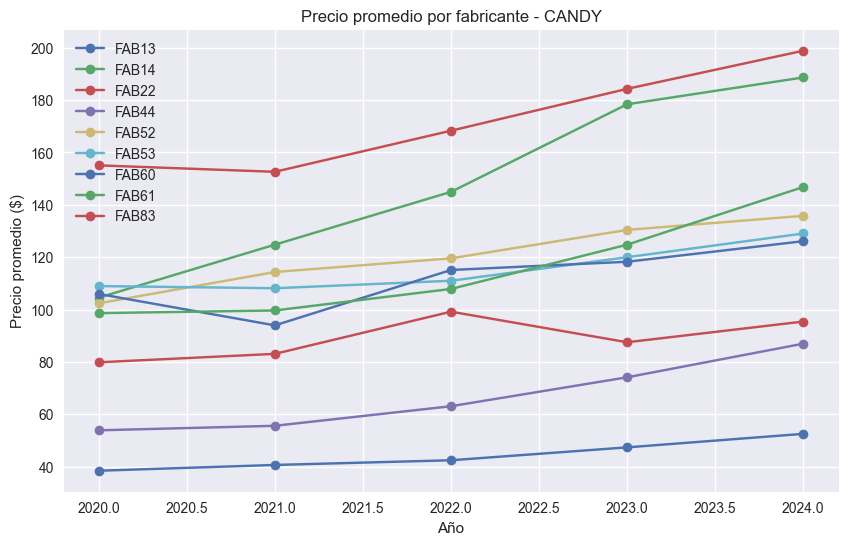

In [70]:
# Gráfico de líneas: precio promedio por año por fabricante
plt.figure(figsize=(10,6))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.plot(subset['ANIO'], subset['PRECIO_PROM'], marker='o', label=fab)

plt.title("Precio promedio por fabricante - CANDY")
plt.xlabel("Año")
plt.ylabel("Precio promedio ($)")
plt.legend()
plt.show()

En este gráfico apreciamos el cambio del precio promedio de los productos de cada fabricante. En la mayoría de los casos no se observa una fuerte relación entre como al incrementar o disminuir el precio de los productos repercute en el valor generado, pues por ejemplo el fabricante de color naranja tuvo dos periodos de incremento en sus precios de la misma proporción y en el gráfico de ventas vemos que en los periodos correspondientes bajó y luego subió. En estos casos podemos concluir que el incremento o disminución del valor generado se debió a otros factores.

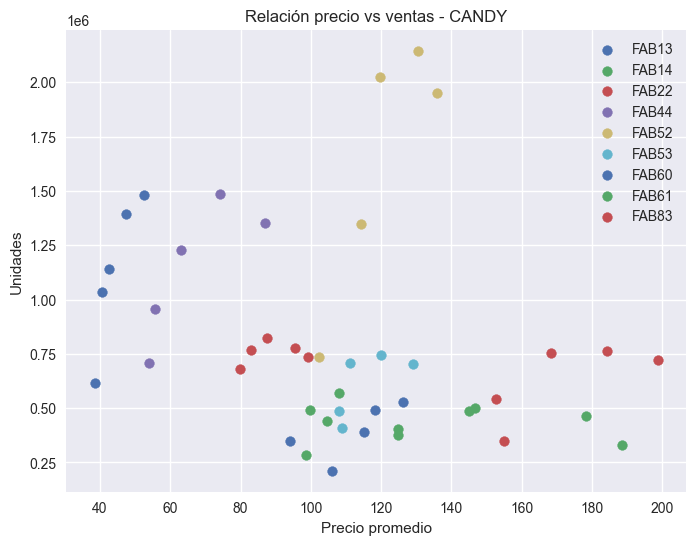

In [71]:
# Gráfico de dispersión: precio promedio vs ventas por fabricante
plt.figure(figsize=(8,6))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.scatter(subset['PRECIO_PROM'], subset['UNIDADES'], label=fab)

plt.title("Relación precio vs ventas - CANDY")
plt.xlabel("Precio promedio")
plt.ylabel("Unidades")
plt.legend()
plt.show()

Por otra parte también podemos ver en este gráfico cómo el incremento o disminución del precio promedio repercute en el volumen de ventas. Aquí podemos apreciar claramente el precio promedio que generalmente favorece a cada fabricante para obtener un mayor número de ventas.

## Objetivo 2

Design and run regression model(s) to estimate price sensitivity (direct price elasticity) by manufacturer (by fabs, not by product).

In [72]:
# ========================
# PARTE 2: Análisis de Demanda
# ========================

import statsmodels.api as sm
import seaborn as sns

# df_sales y df_catalog ya están cargados.

df_candy_sales['FECHA'] = pd.to_datetime(df_candy_sales['FECHA'])

# Agrupar por FAB y FECHA, y filtrar por top_fabs
df_fabricante = df_candy_sales[df_candy_sales['FAB'].isin(top_fabs)].groupby(['FAB', 'FECHA']).agg({
    'UNIDADES': 'sum',
    'VALOR': 'sum'
}).reset_index()

df_fabricante['PRECIO_PROMEDIO'] = df_fabricante['VALOR'] / df_fabricante['UNIDADES']
#display(df_fabricante)

df_fabricante_top = df_candy_sales[df_candy_sales['FAB'].isin(top_fabs)].groupby(['FAB']).agg({
    'UNIDADES': 'sum',
    'VALOR': 'sum'
}).reset_index()


In [73]:
ventas_t = df_fabricante_top['VALOR'].sum()
unidades_t = df_fabricante_top['UNIDADES'].sum()
df_fabricante_top['CUOTA_MERCADO_VALOR'] = ((df_fabricante_top['VALOR'] / ventas_t) * 100).round(2)
df_fabricante_top['CUOTA_MERCADO_UNIDADES'] = ((df_fabricante_top['UNIDADES'] / unidades_t) * 100).round(2)
df_fabricante_top = df_fabricante_top.sort_values(by='CUOTA_MERCADO_VALOR', ascending=False)
# df_fabricante_top.head()

df_modeling = df_fabricante.copy()
df_modeling = df_modeling[(df_modeling['UNIDADES'] > 0) & (df_modeling['PRECIO_PROMEDIO'] > 0)].copy()

df_modeling['ln_cantidad'] = np.log(df_modeling['UNIDADES'])
df_modeling['ln_precio'] = np.log(df_modeling['PRECIO_PROMEDIO'])

FABS = df_modeling['FAB'].unique()

resultados = {}

for FAB in FABS:
    df_fab_data = df_modeling[df_modeling['FAB'] == FAB].copy()

    if len(df_fab_data) > 1:
        y = df_fab_data['ln_cantidad']
        x = df_fab_data['ln_precio']
        x = sm.add_constant(x)

        model = sm.OLS(y, x).fit()

        interseccion = model.params['const']
        elasticidad = model.params['ln_precio']
        r2 = model.rsquared

        t_stat = model.tvalues['ln_precio']
        p_value = model.pvalues['ln_precio']
        conf_int = model.conf_int()

        resultados[FAB] = {
            'interseccion': interseccion,
            'coeficiente': elasticidad,
            'r2': r2,
            't_stat': t_stat,
            'p_value': p_value
        }


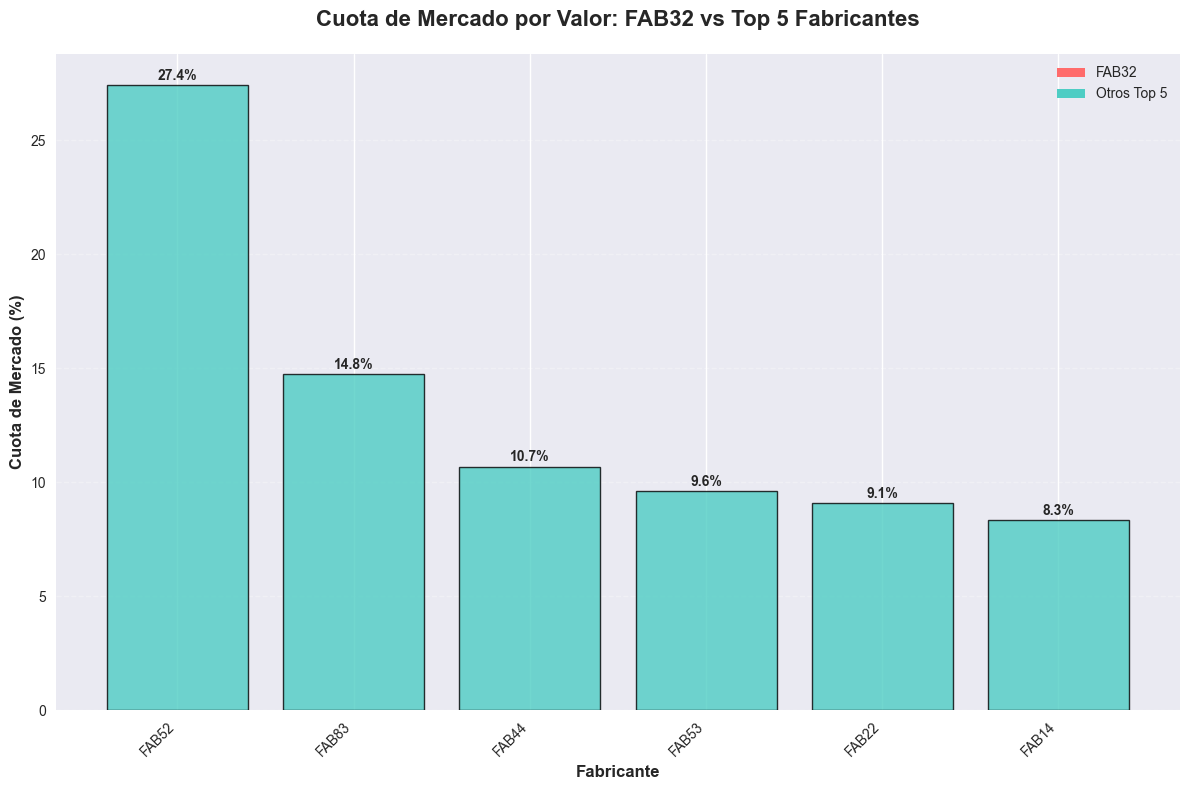

In [74]:
df_resultados = pd.DataFrame(resultados).T
df_resultados.head()


datos_grafico = df_fabricante_top.head(6)
plt.figure(figsize=(12, 8))

plt.style.use('seaborn-v0_8')
colors = ['#FF6B6B' if fab == 'FAB32' else '#4ECDC4' for fab in datos_grafico['FAB']]

bars = plt.bar(datos_grafico['FAB'],
               datos_grafico['CUOTA_MERCADO_VALOR'],
               color=colors,
               alpha=0.8,
               edgecolor='black',
               linewidth=1)

plt.title('Cuota de Mercado por Valor: FAB32 vs Top 5 Fabricantes',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fabricante', fontsize=12, fontweight='bold')
plt.ylabel('Cuota de Mercado (%)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', label='FAB32'),
                   Patch(facecolor='#4ECDC4', label='Otros Top 5')]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

COMPARACIÓN DE CUOTAS DE MERCADO
  FAB  CUOTA_MERCADO_VALOR  CUOTA_MERCADO_UNIDADES
FAB52                27.41                   22.86
FAB83                14.75                    8.71
FAB44                10.69                   15.96
FAB53                 9.60                    8.50
FAB22                 9.10                   10.55
FAB14                 8.34                    5.86


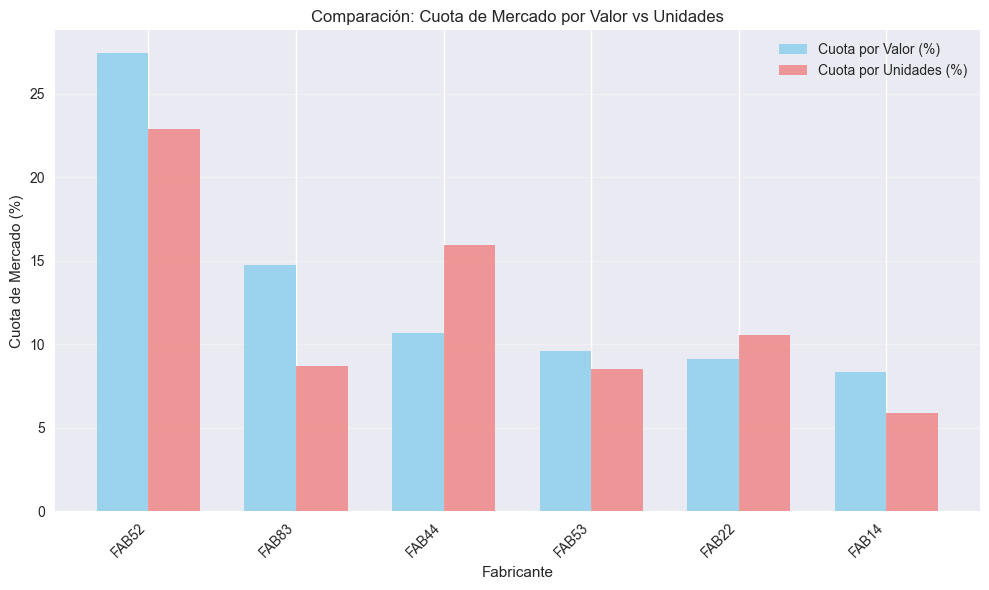

In [75]:


print("COMPARACIÓN DE CUOTAS DE MERCADO")
print("="*50)
print(datos_grafico[['FAB', 'CUOTA_MERCADO_VALOR', 'CUOTA_MERCADO_UNIDADES']].to_string(index=False))

plt.figure(figsize=(10, 6))
x = range(len(datos_grafico))
width = 0.35
plt.bar([i - width/2 for i in x], datos_grafico['CUOTA_MERCADO_VALOR'],
        width, label='Cuota por Valor (%)', color='skyblue', alpha=0.8)
plt.bar([i + width/2 for i in x], datos_grafico['CUOTA_MERCADO_UNIDADES'],
        width, label='Cuota por Unidades (%)', color='lightcoral', alpha=0.8)
plt.xlabel('Fabricante')
plt.ylabel('Cuota de Mercado (%)')
plt.title('Comparación: Cuota de Mercado por Valor vs Unidades')
plt.xticks(x, datos_grafico['FAB'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Objetivo 3
Considering ONLY the top 2 fabs, propose how you could improve your model(s) design to incorporate the following factors: cross-price elasticity, seasonality and growth trend.

In [76]:
top2_fabs = df_candy_fab_top.head(2)['FAB'].tolist()
df_top2 = df_candy_perf_top[df_candy_perf_top['FAB'].isin(top2_fabs)].copy()

df_top2

# Pivot: years as index, FAB as columns
q_pivot = df_top2.pivot(index='ANIO', columns='FAB', values='UNIDADES')
p_pivot = df_top2.pivot(index='ANIO', columns='FAB', values='PRECIO_PROM')

dq = q_pivot.pct_change().dropna()
dp = p_pivot.pct_change().dropna()

In [77]:
fab1, fab2 = top2_fabs

E_12 = (dq[fab1] / dp[fab2]).mean()   # elasticity of fab1 wrt fab2 price
E_21 = (dq[fab2] / dp[fab1]).mean()   # elasticity of fab2 wrt fab1 price

print(f"Cross-price elasticity of {fab1} wrt {fab2}: {E_12:.3f}")
print(f"Cross-price elasticity of {fab2} wrt {fab1}: {E_21:.3f}")


Cross-price elasticity of FAB52 wrt FAB83: -11.974
Cross-price elasticity of FAB83 wrt FAB52: 2.999


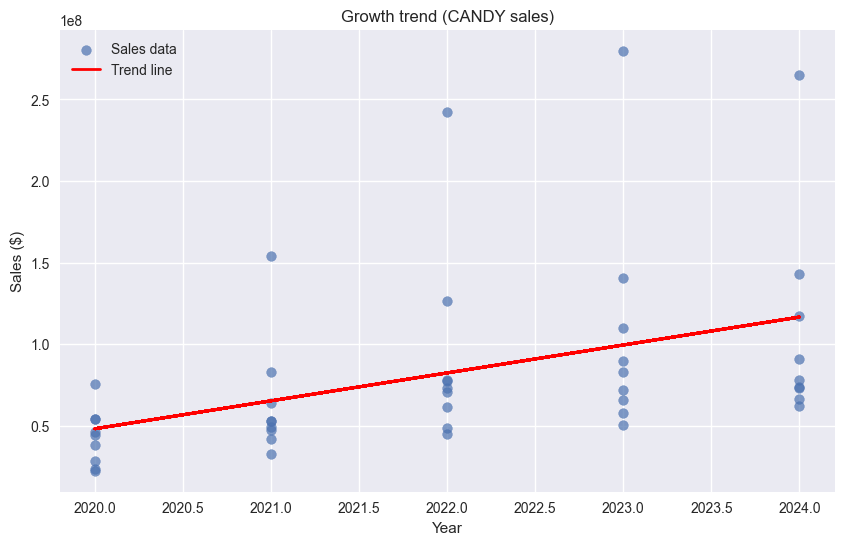

In [78]:
# Scatter plot of sales by year
x = df_candy_perf_top['ANIO'].values
y = df_candy_perf_top['VALOR'].values

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.7, label="Sales data")

# Fit a linear regression (trend line)
coef = np.polyfit(x, y, 1)      # degree=1 → linear
poly1d_fn = np.poly1d(coef)     # build function from coefficients

plt.plot(x, poly1d_fn(x), color="red", linewidth=2, label="Trend line")

plt.title("Growth trend (CANDY sales)")
plt.xlabel("Year")
plt.ylabel("Sales ($)")
plt.legend()
plt.show()

C:\Users\Imanol\AppData\Local\Temp\ipykernel_17056\3790007784.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_monthly.groupby(pd.Grouper(key='FECHA', freq='M'))['VALOR'].sum().reset_index()


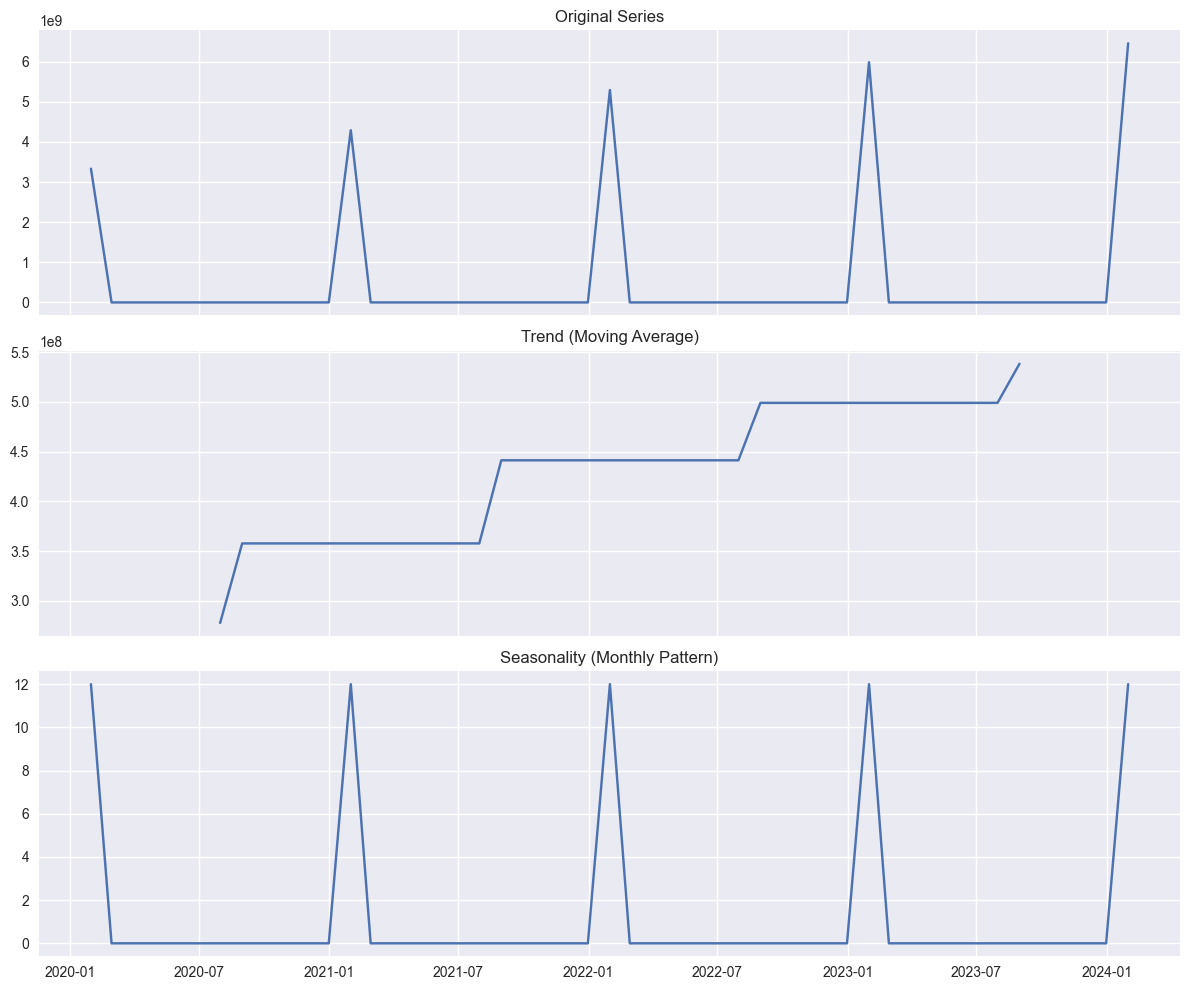

In [82]:

df_monthly = df_sales.copy() 
df_monthly['FECHA'] = pd.to_datetime(df_monthly['FECHA']) 
df_monthly = df_monthly.groupby(pd.Grouper(key='FECHA', freq='M'))['VALOR'].sum().reset_index()
df_monthly['Trend'] = df_monthly['VALOR'].rolling(window=12, center=True).mean()

df_monthly['Detrended'] = df_monthly['VALOR'] / df_monthly['Trend']
df_monthly['Month'] = df_monthly['FECHA'].dt.month

# Average seasonal effect for each month
seasonal_factors = df_monthly.groupby('Month')['Detrended'].mean()
df_monthly['Seasonality'] = df_monthly['Month'].map(seasonal_factors)


fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axs[0].plot(df_monthly['FECHA'], df_monthly['VALOR'])
axs[0].set_title("Original Series")

axs[1].plot(df_monthly['FECHA'], df_monthly['Trend'])
axs[1].set_title("Trend (Moving Average)")

axs[2].plot(df_monthly['FECHA'], df_monthly['Seasonality'])
axs[2].set_title("Seasonality (Monthly Pattern)")


plt.tight_layout()
plt.show()


## Objetivo 4

Prediccion para 24 meses con gradiente descendiente 

In [83]:

top5_fabs = df_candy_fab_top.head(5)['FAB'].tolist()
print("Top 5 fabricantes:", top5_fabs)

df_model_data = df_candy_perf_top[df_candy_perf_top['FAB'].isin(top5_fabs)].copy()


#Función de hipótesis
def hyp(x, theta, b):
    y_hat = b
    for i in range(len(x)):
        y_hat += x[i] * theta[i]
    return y_hat

#Función de costo
def mse(x, theta, b, y):
    cost = 0
    m = len(x)
    for i in range(m):
        cost += (hyp(x[i], theta, b) - y[i])**2
    return cost / m

#Función de actualización
def update(x, theta, b, y, alfa):
    new_theta = theta.copy()
    m = len(x)
    n = len(theta)

    # Actualizar theta
    for j in range(n):
        grad_theta = 0
        for i in range(m):
            grad_theta += (hyp(x[i], theta, b) - y[i]) * x[i][j]
        new_theta[j] = theta[j] - (alfa/m) * grad_theta

    # Actualizar b
    grad_b = 0
    for i in range(m):
        grad_b += (hyp(x[i], theta, b) - y[i])
    new_b = b - (alfa/m) * grad_b

    return new_theta, new_b



resultados_pronostico = {}

for fab in top5_fabs:
    
    fab_data = df_model_data[df_model_data['FAB'] == fab].sort_values('ANIO')
    
    if len(fab_data) < 3:
        print(f" Datos insuficientes para {fab}")
        continue
    
    years = fab_data['ANIO'].values
    years_norm = (years - years.min()) / (years.max() - years.min())  
    
    features_raw = []
    for i, year in enumerate(years_norm):
        features_raw.append([
            year,                           # tendencia lineal
            year**2,                        # tendencia cuadrática  
            np.sin(2*np.pi*i/5),           # componente cíclico (5 años)
            np.cos(2*np.pi*i/5)            # componente cíclico (5 años)
        ])
    

    ventas_raw = fab_data['VALOR'].values
    precios_raw = fab_data['PRECIO_PROM'].values
    
    x_raw = np.array(features_raw)
    x_mean = np.mean(x_raw, axis=0)
    x_std = np.std(x_raw, axis=0)
    x_std[x_std == 0] = 1  
    x = ((x_raw - x_mean) / x_std).tolist()
    
    #  VENTAS 
    

    y_mean_ventas = np.mean(ventas_raw)
    y_std_ventas = np.std(ventas_raw)
    y_ventas = ((ventas_raw - y_mean_ventas) / y_std_ventas).tolist()
    

    theta_ventas = [0.0] * len(x[0])
    b_ventas = 0.0
    alfa = 0.01
    epoca = 2000  
    errores_ventas = []
    

    i = 0
    while i < epoca:
        error_actual = mse(x, theta_ventas, b_ventas, y_ventas)
        errores_ventas.append(error_actual)
        
        if error_actual == 0:
            break
        
        theta_ventas, b_ventas = update(x, theta_ventas, b_ventas, y_ventas, alfa)
        i += 1
    
    print(f"Error final ventas: {errores_ventas[-1]:.6f}")
    
    # PRECIOS

    y_mean_precios = np.mean(precios_raw)
    y_std_precios = np.std(precios_raw)
    y_precios = ((precios_raw - y_mean_precios) / y_std_precios).tolist()
    
    theta_precios = [0.0] * len(x[0])
    b_precios = 0.0
    errores_precios = []
    
    i = 0
    while i < epoca:
        error_actual = mse(x, theta_precios, b_precios, y_precios)
        errores_precios.append(error_actual)
        
        if error_actual == 0:
            break
        
        theta_precios, b_precios = update(x, theta_precios, b_precios, y_precios, alfa)
        i += 1
    
    print(f"Error final precios: {errores_precios[-1]:.6f}")
    
    #PRONÓSTICOS PARA 24 MESES
    last_year = years.max()
    future_years = np.arange(last_year + 1, last_year + 3)  # 2025, 2026
    future_years_norm = (future_years - years.min()) / (years.max() - years.min())
    
    future_features_raw = []
    for i, year in enumerate(future_years_norm):
        future_features_raw.append([
            year,
            year**2,
            np.sin(2*np.pi*(len(years)+i)/5),
            np.cos(2*np.pi*(len(years)+i)/5)
        ])
    

    x_future_raw = np.array(future_features_raw)
    x_future = ((x_future_raw - x_mean) / x_std).tolist()
    
    
    ventas_pred_norm = [hyp(xi, theta_ventas, b_ventas) for xi in x_future]
    precios_pred_norm = [hyp(xi, theta_precios, b_precios) for xi in x_future]
    
    
    ventas_pred = [yp * y_std_ventas + y_mean_ventas for yp in ventas_pred_norm]
    precios_pred = [yp * y_std_precios + y_mean_precios for yp in precios_pred_norm]
    
    
    ventas_pred = [max(v, 0) for v in ventas_pred]
    precios_pred = [max(p, 0.1) for p in precios_pred]
    
    resultados_pronostico[fab] = {
        'años_historicos': years,
        'ventas_historicas': ventas_raw,
        'precios_historicos': precios_raw,
        'años_futuros': future_years,
        'ventas_futuras': ventas_pred,
        'precios_futuros': precios_pred,
        'errores_ventas': errores_ventas,
        'errores_precios': errores_precios
    }
    
    print(f"Ventas 2025: ${ventas_pred[0]:,.0f}, Precios 2025: ${precios_pred[0]:.2f}")


Top 5 fabricantes: ['FAB52', 'FAB83', 'FAB44', 'FAB53', 'FAB22']
Error final ventas: 0.000644
Error final precios: 0.017782
Ventas 2025: $296,619,293, Precios 2025: $149.13
Error final ventas: 0.001841
Error final precios: 0.004353
Ventas 2025: $160,091,110, Precios 2025: $204.52
Error final ventas: 0.005435
Error final precios: 0.000345
Ventas 2025: $126,754,600, Precios 2025: $97.75
Error final ventas: 0.003871
Error final precios: 0.000341
Ventas 2025: $92,619,623, Precios 2025: $134.98
Error final ventas: 0.007987
Error final precios: 0.324421
Ventas 2025: $83,091,279, Precios 2025: $105.77


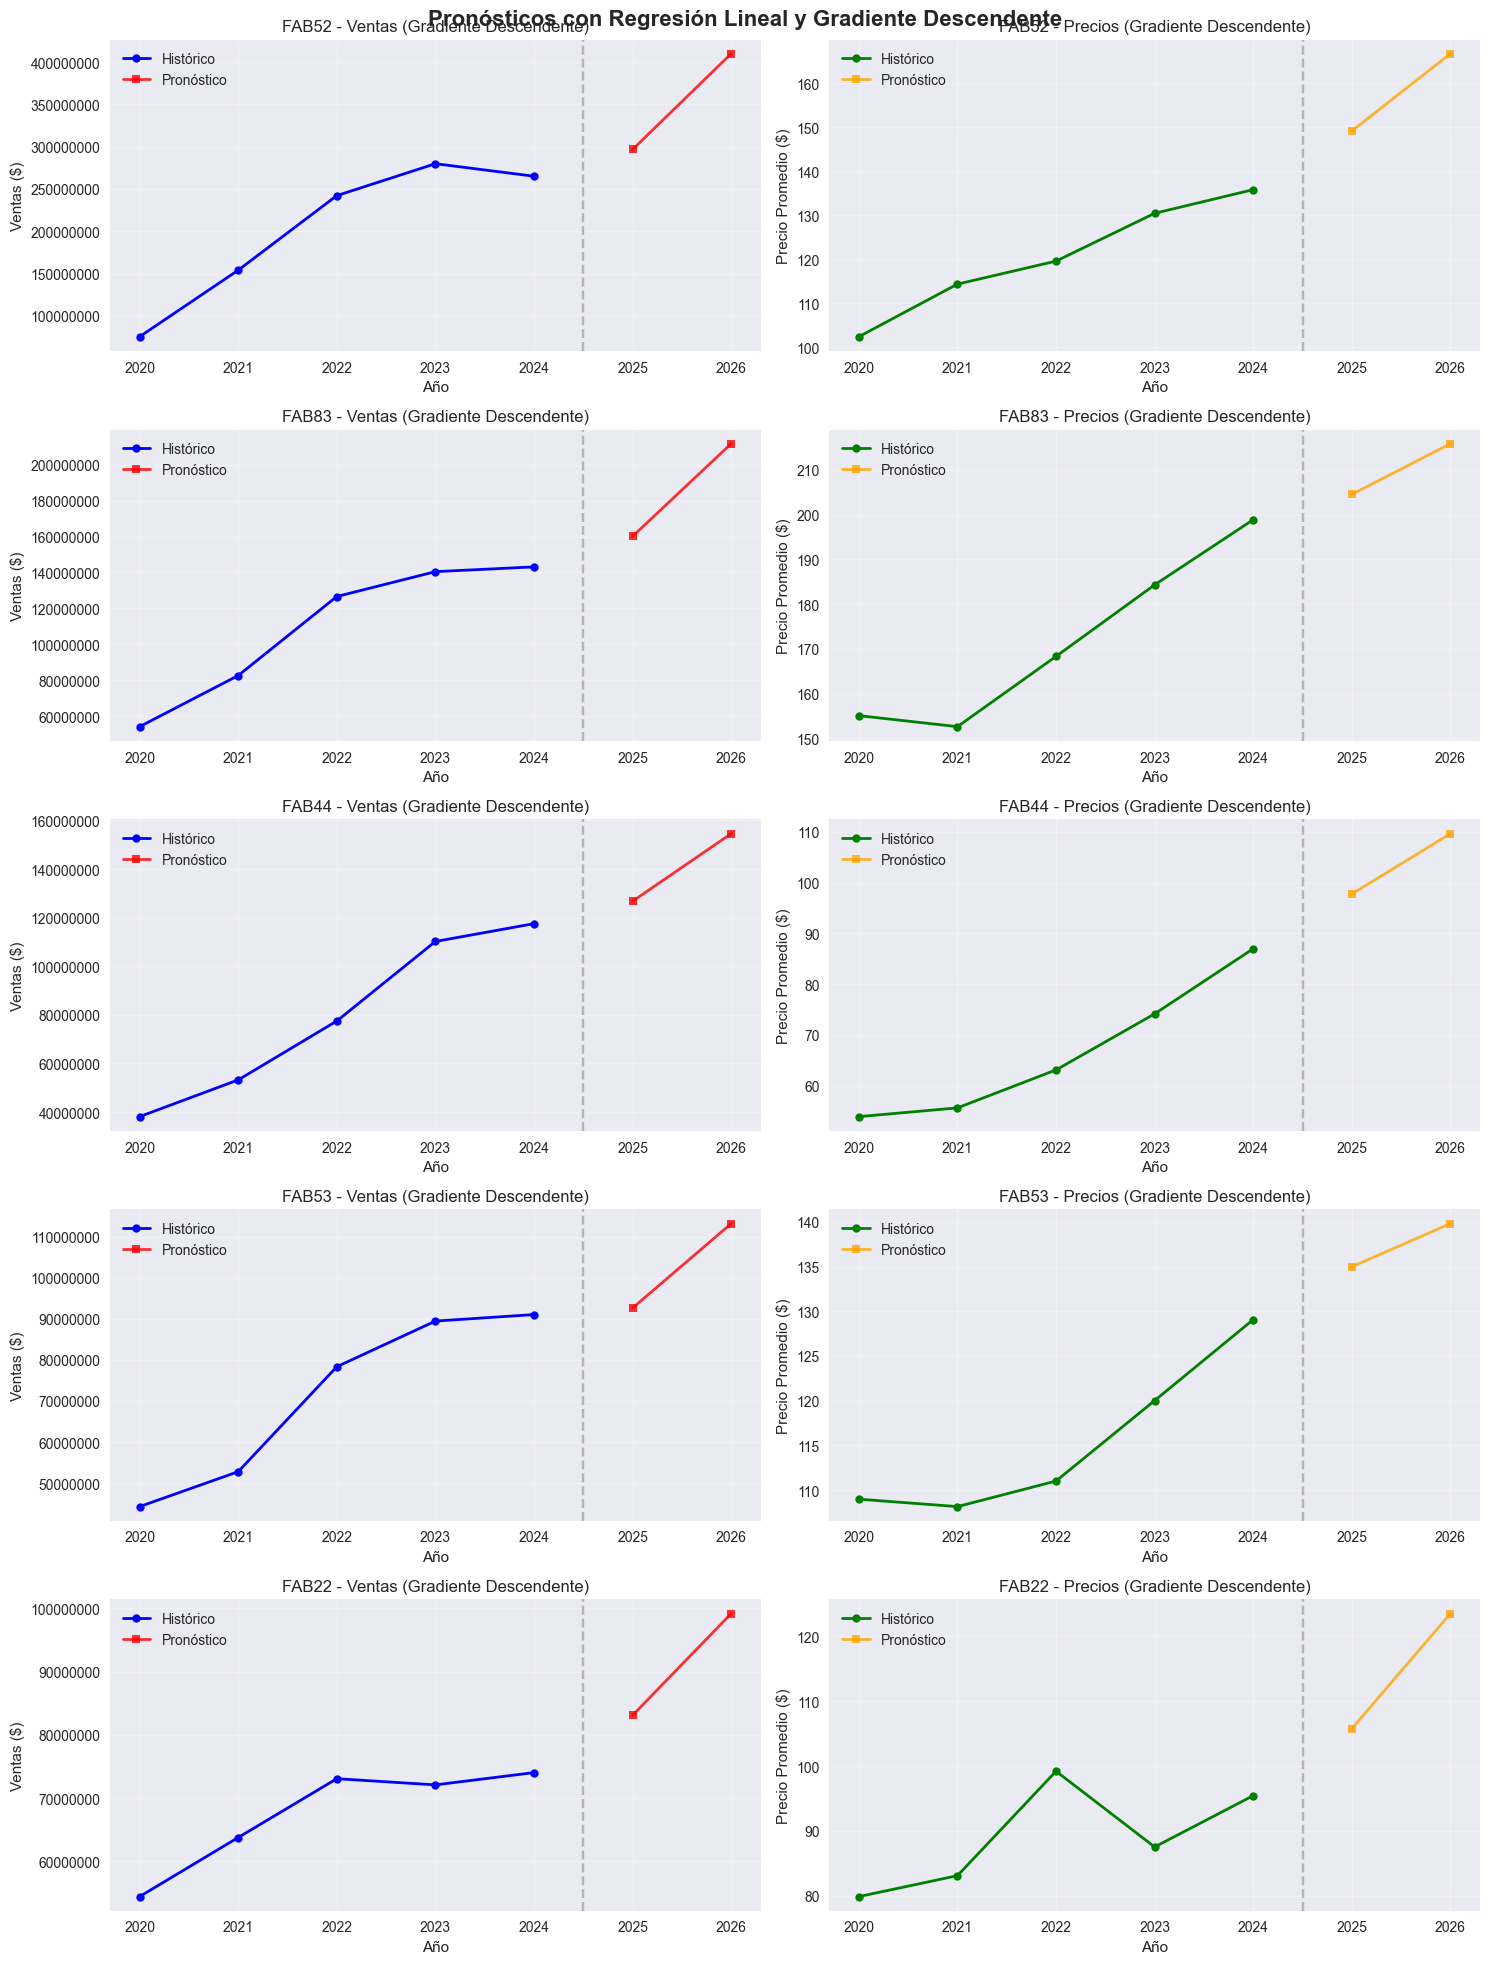


PRONÓSTICOS PARA LOS PRÓXIMOS 24 MESES (2025-2026)
RESUMEN POR FABRICANTE Y AÑO:
            Ventas_Anuales  Precio_Promedio  Ingresos_Anuales
FAB   Año                                                    
FAB22 2025       785619.36           105.77       83091278.82
      2026       802942.06           123.51       99173769.76
FAB44 2025      1296692.04            97.75      126754599.70
      2026      1409589.92           109.65      154568274.55
FAB52 2025      1988979.14           149.13      296619292.74
      2026      2458304.66           166.71      409829372.81
FAB53 2025       686190.12           134.98       92619623.16
      2026       809462.40           139.80      113161338.89
FAB83 2025       782760.60           204.52      160091109.91
      2026       980414.23           215.86      211631895.46


In [81]:

fig, axes = plt.subplots(len(resultados_pronostico), 2, figsize=(15, 4*len(resultados_pronostico)))
if len(resultados_pronostico) == 1:
    axes = axes.reshape(1, -1)

for i, (fab, data) in enumerate(resultados_pronostico.items()):
    
    
    ax1 = axes[i, 0] if len(resultados_pronostico) > 1 else axes[0]
    
    
    ax1.plot(data['años_historicos'], data['ventas_historicas'], 
             'o-', color='blue', linewidth=2, markersize=6, label='Histórico')
    
    
    ax1.plot(data['años_futuros'], data['ventas_futuras'], 
             's-', color='red', linewidth=2, markersize=6, label='Pronóstico', alpha=0.8)
    
    
    ax1.axvline(x=2024.5, color='gray', linestyle='--', alpha=0.5)
    
    ax1.set_title(f'{fab} - Ventas (Gradiente Descendente)')
    ax1.set_xlabel('Año')
    ax1.set_ylabel('Ventas ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.ticklabel_format(style='plain', axis='y')
    
    ax2 = axes[i, 1] if len(resultados_pronostico) > 1 else axes[1]
    
   
    ax2.plot(data['años_historicos'], data['precios_historicos'], 
             'o-', color='green', linewidth=2, markersize=6, label='Histórico')

    ax2.plot(data['años_futuros'], data['precios_futuros'], 
             's-', color='orange', linewidth=2, markersize=6, label='Pronóstico', alpha=0.8)
    
    ax2.axvline(x=2024.5, color='gray', linestyle='--', alpha=0.5)
    
    ax2.set_title(f'{fab} - Precios (Gradiente Descendente)')
    ax2.set_xlabel('Año')
    ax2.set_ylabel('Precio Promedio ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.suptitle('Pronósticos con Regresión Lineal y Gradiente Descendente', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# TABLA DE PRONÓSTICOS (24 MESES)


print("\n" + "="*80)
print("PRONÓSTICOS PARA LOS PRÓXIMOS 24 MESES (2025-2026)")
print("="*80)

tabla_pronosticos = []
for fab, data in resultados_pronostico.items():
    for i, año in enumerate(data['años_futuros']):
        for mes in range(1, 13):
            tabla_pronosticos.append({
                'FAB': fab,
                'Año': año,
                'Mes': mes,
                'Ventas_Anuales': data['ventas_futuras'][i] / data['precios_futuros'][i],  # Unidades = Ingresos / Precio
                'Ventas_Mensuales': (data['ventas_futuras'][i] / data['precios_futuros'][i]) / 12,  # Unidades mensuales
                'Precio_Promedio': data['precios_futuros'][i],
                'Ingresos_Mensuales': data['ventas_futuras'][i] / 12  # Ingresos mensuales en dólares
            })

df_tabla_pronosticos = pd.DataFrame(tabla_pronosticos)


print("RESUMEN POR FABRICANTE Y AÑO:")
resumen_anual = df_tabla_pronosticos.groupby(['FAB', 'Año']).agg({
    'Ventas_Anuales': 'first',
    'Precio_Promedio': 'first',
    'Ingresos_Mensuales': 'sum' 
}).round(2)
resumen_anual.rename(columns={'Ingresos_Mensuales': 'Ingresos_Anuales'}, inplace=True)


pd.set_option('display.float_format', '{:.2f}'.format)
print(resumen_anual)
pd.reset_option('display.float_format')


# GUÍA PARA INTERPRETAR LAS GRÁFICAS DE PRONÓSTICOS

### **Interpretación por fabricante:**

**FAB52 (Líder del mercado):**
-  **Ventas**: Crecimiento sostenido, de $265M → $297M → $410M
-  **Precios**: Aumentan gradualmente de $136 → $149 → $167
-  **Tendencia**: Muy positiva, consolidando liderazgo

**FAB83 (Segundo lugar):**
-  **Ventas**: Crecimiento estable, de $143M → $160M → $212M
-  **Precios**: Incremento moderado de $199 → $205 → $216
-  **Tendencia**: Sólida, manteniendo posición

**FAB44 (Tercer lugar):**
-  **Ventas**: Crecimiento constante, de $118M → $127M → $155M
-  **Precios**: Aumento significativo de $87 → $98 → $110
-  **Tendencia**: Buena, con mejora en precios

**FAB53 (Cuarto lugar):**
-  **Ventas**: Crecimiento inicial lento, luego se acelera
-  **Precios**: Incremento moderado y estable
-  **Tendencia**: Conservadora pero sólida

**FAB22 (Quinto lugar):**
-  **Ventas**: Crecimiento sostenido del más pequeño
-  **Precios**: Buenos aumentos, mejorando márgenes
-  **Tendencia**: Positiva para el segmento

### **Señales importantes a buscar:**

1. **Pendiente de las líneas**: 
   - Hacia arriba = Crecimiento
   - Horizontal = Estancamiento
   - Hacia abajo = Declive

2. **Separación entre histórico y pronóstico**:
   - Cambios abruptos pueden indicar sobre/sub estimación
   - Continuidad suave sugiere pronósticos realistas

3. **Relación ventas-precios**:
   - Ambos suben = Mercado en expansión
   - Ventas suben, precios bajan = Competencia por volumen
   - Ventas bajan, precios suben = Mercado premium
